In [1]:
!pip install datasets

In [13]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth',400)
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup



from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score


import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords


from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification , AutoTokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU,  BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, ZeroPadding1D, Add, Flatten, Dot, Concatenate, Lambda
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D, TimeDistributed, Attention
from keras.layers import InputSpec, Layer
from keras.models import Model, load_model
from keras.optimizers import Adam,Adagrad
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

In [14]:
import pandas as pd
import time
from transformers import pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef, cohen_kappa_score, log_loss
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Valid.csv
/kaggle/input/Train.csv
/kaggle/input/Test.csv


In [16]:
models = [
    "wrmurray/roberta-base-finetuned-imdb",
    "JiaqiLee/imdb-finetuned-bert-base-uncased",
]

In [17]:
df1= pd.read_csv("/kaggle/input/Train.csv")
df2= pd.read_csv("/kaggle/input/Valid.csv")

dataset = pd.concat([df1, df2])


In [18]:
dataset['text'] = dataset['text'].str.lower()

In [19]:
import string

# Removing punctuation
exclude = set(string.punctuation)

def remove_punctuation(x):
    try:
        x = ''.join(ch for ch in x if ch not in exclude)
    except:
        pass
    return x

dataset['text'] = dataset['text'].apply(remove_punctuation)

dataset.head()


,text,label
0,i grew up b 1965 watching and loving the thunderbirds all my mates at school watched we played thunderbirds before school during lunch and after school we all wanted to be virgil or scott no one wanted to be alan counting down from 5 became an art form i took my children to see the movie hoping they would get a glimpse of what i loved as a child how bitterly disappointing the only high point w...,0
1,when i put this movie in my dvd player and sat down with a coke and some chips i had some expectations i was hoping that this movie would contain some of the strongpoints of the first movie awsome animation good flowing story excellent voice cast funny comedy and a kickass soundtrack but to my disappointment not any of this is to be found in atlantis milos return had i read some reviews first ...,0
2,why do people who do not know what a particular time in the past was like feel the need to try to define that time for others replace woodstock with the civil war and the apollo moonlanding with the titanic sinking and youve got as realistic a flick as this formulaic soap opera populated entirely by lowlife trash is this what kids who were too young to be allowed to go to woodstock and who fai...,0
3,even though i have great interest in biblical movies i was bored to death every minute of the movie everything is bad the movie is too long the acting is most of the time a joke and the script is horrible i did not get the point in mixing the story about abraham and noah together so if you value your time and sanity stay away from this horror,0
4,im a die hard dads army fan and nothing will ever change that i got all the tapes dvds and audiobooks and every time i watchlisten to them its brand new br br the film the film is a re run of certain episodes man and the hour enemy within the gates battle school and numerous others with a different edge introduction of a new general instead of captain square was a brilliant move especially wh...,1


In [20]:
import re
# Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
# Apply function on review column
dataset['text'] = dataset['text'].apply(denoise_text)

In [21]:
import nltk
nltk.download('stopwords')

stop=set(stopwords.words('english'))
stopword_list=nltk.corpus.stopwords.words('english')
print(stop)

tokenizer=TweetTokenizer()



def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

#stop = stopwords.words('english')

dataset['text'] = dataset['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'in', 'all', "should've", "needn't", 'those', 'aren', 'she', 'do', 'during', 'has', 'll', 'me', 'through', "doesn't", "isn't", 'had', 'himself', 'are', 'him', 'further', "won't", 'is', 'hers', 'that', 'm', 'don', 'i', 'doesn', 'ain', "shouldn't", 'but', 'about', 'from', 'didn', 'herself', 'yours', 'have', 'being', "couldn't", 'below', 'or', 'each', 'any', 'while', 'how', 'only', 'by', 'they', 're', "it's", 'most', 'ma', "hasn't", 'does', 'shan', 'her', 'what', 'both', 'mustn', 'won', 'such', 'been', 'more', 'then', 'no', 'at', 'between', 'off', 'its', 'his', 'shouldn', 'with', 'couldn', "that'll", 'now', 'he', 'were', 'yourselves', 'doing', 'until', 'where', 'having', 'their', "don't", 'hadn', 'can', 'your', "you'll", 'am', "you're", 'themselves', 'own', 'not', 'same', 'needn', 'ourselves', 'haven', 'very', 'wasn', 'just', "aren't", 'hasn', "mightn't", 'o', 'woul

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
dataset['text'] = dataset['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [34]:
newDf = dataset[dataset['text'].apply(lambda x: len(x) < 512)]
newDf.head()

,text,label
3,even though great interest biblical movies bored death every minute movie everything bad movie long acting time joke script horrible get point mixing story abraham noah together value time sanity stay away horror,0
5,terrible movie everyone said made laugh cameo appearance scott mcnealy giving award one murdered programmers front wall sun logos mcnealy ceo sun microsystem company practically defines hatred microsoft instrumental filing antitrust complaints microsoft silly enough think bad movie would add fuel firebr br theres public record see suns involvement clearly makers movie know scott mcnealy intere...,0
10,cant believe people looking plot film laural hardy lighten already two riot comic genius funny today 70 years ago filthy word either mouth able keep audiences stitches comedy wasnt sophisticated stretch whoopee cushion cant make grin theres reason watch stuff guys simpler time people laughed stuff funny without plot guess takes simple mind enjoy stuff qualify two man comedy teams dont compute ...,1
12,always huge fan homicide life street heard reunion movie coming couldnt waitbr br let say disappointed one powerful 2 hours television ive ever seen great see everyone back biggest pleasure andre braugher back relationship pembleton bayliss always strongest part alltogether great show,1
14,halfhearted attempt bring elvis presley modern day despite sexy little shower scene pseudoplayboy magazine subplot presley surrounded old coy winking clichés woman picks ep beach proceeds take lifeand doesnt seem care dick sargent grueling another sidebar porter rudy vallee try hard elvis two bosses hes moonlighting see songs quite good especially almost love want see looser hipper updated elv...,0


In [36]:
FORMAT_LABELS = {
    'label_0': 0,
    "label_1": 1,
    "positive": 1,
    "negative": 0,
    'neg': 0,
    'pos': 1
}

In [37]:
def evaluate_model(model_name, epochs=3):
    results = []

    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch}:")
        print('model initialized')
        pipe = pipeline("text-classification", model=model_name)
        start_time = time.time()
        res = pipe(texts)
        end_time = time.time()

        predicted_labels = list(map(lambda x: FORMAT_LABELS.get(x['label'].lower(), 0), res))
        probs = [item['score'] for item in res]
        print('Calculate evaluation metrics')
        # Calculate evaluation metrics
        accuracy = accuracy_score(labels, predicted_labels)
        logloss = log_loss(labels, probs)

        # Calculate training time
        training_time = end_time - start_time

        results.append({
            "Epoch": epoch,
            "Model": model_name,
            "Accuracy": accuracy,
            "Time (s)": training_time,
            'Log Loss': logloss,
        })

    return results

In [38]:
results_bert = evaluate_model(models[1])
results_roberta = evaluate_model(models[0])

Epoch 1:
model initialized


config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Calculate evaluation metrics
Epoch 2:
model initialized
Calculate evaluation metrics
Epoch 3:
model initialized
Calculate evaluation metrics
Epoch 1:
model initialized


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Calculate evaluation metrics
Epoch 2:
model initialized
Calculate evaluation metrics
Epoch 3:
model initialized
Calculate evaluation metrics


Text(0, 0.5, 'Accuracy')

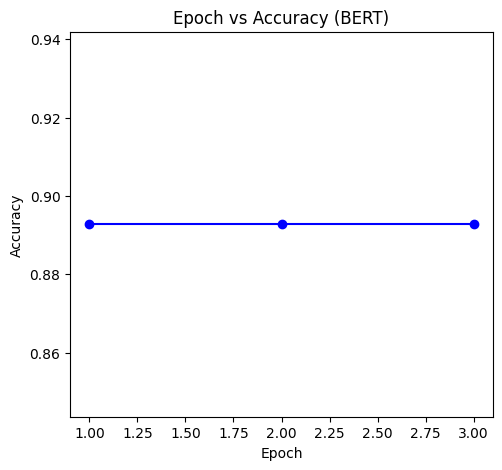

In [39]:
plt.figure(figsize=(12, 5))

# Accuracy plot for BERT
plt.subplot(1, 2, 1)
epochs_bert = np.arange(1, len(results_bert) + 1)
accuracies_bert = [result['Accuracy'] for result in results_bert]
plt.plot(epochs_bert, accuracies_bert, marker='o', color='b')
plt.title('Epoch vs Accuracy (BERT)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

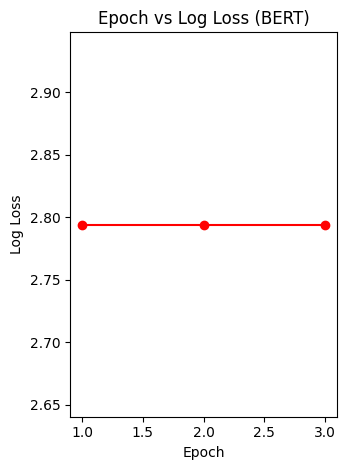

In [40]:
# Loss plot for BERT
plt.subplot(1, 2, 2)
losses_bert = [result['Log Loss'] for result in results_bert]
plt.plot(epochs_bert, losses_bert, marker='o', color='r')
plt.title('Epoch vs Log Loss (BERT)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Accuracy')

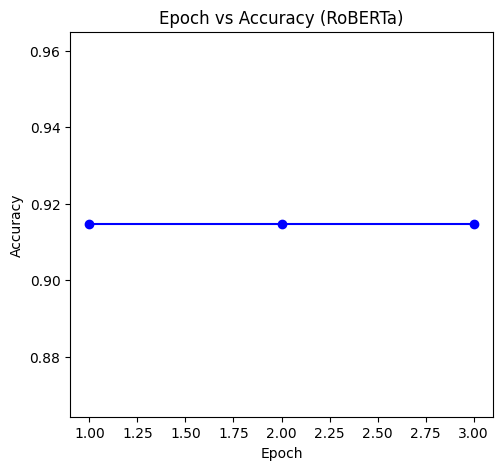

In [41]:
plt.figure(figsize=(12, 5))

# Accuracy plot for RoBERTa
plt.subplot(1, 2, 1)
epochs_roberta = np.arange(1, len(results_roberta) + 1)
accuracies_roberta = [result['Accuracy'] for result in results_roberta]
plt.plot(epochs_roberta, accuracies_roberta, marker='o', color='b')
plt.title('Epoch vs Accuracy (RoBERTa)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


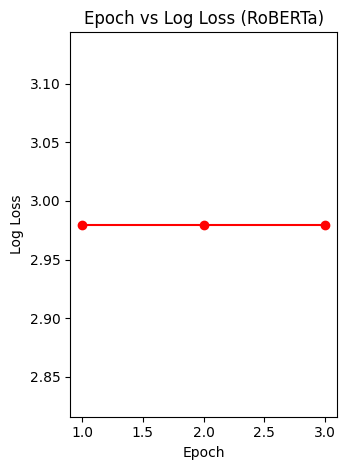

In [42]:
plt.subplot(1, 2, 2)
losses_roberta = [result['Log Loss'] for result in results_roberta]
plt.plot(epochs_roberta, losses_roberta, marker='o', color='r')
plt.title('Epoch vs Log Loss (RoBERTa)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')

plt.tight_layout()
plt.show()

In [47]:
test_data = pd.read_csv("/kaggle/input/Test.csv")

from transformers import AutoTokenizer
def create_submission(model_name, test_data):
    pipe = pipeline("text-classification", model=model_name)
    predictions = []
    for text in test_data['text'].tolist():
        # Truncate the text to fit within the model's max length
        truncated_text = text[:512]
        prediction = pipe(truncated_text)
        predictions.append(prediction[0])
    predicted_labels = list(map(lambda x: FORMAT_LABELS.get(x['label'].lower(), 0), predictions))
    submission = pd.DataFrame({
          # assuming 'id' is the column in test_data
        'label': predicted_labels
    })
    # Replace forward slash in the model name with an underscore
    filename = f'/kaggle/working/{model_name.replace("/", "_")}_submission2.csv'
    submission.to_csv(filename, index=False)

# Create submission files for both models
create_submission(models[0], test_data)
create_submission(models[1], test_data)
